In [14]:
import os

import cv2
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append("/kaggle/src/")

from model.model_module import ModelModule
from conf import ExpConfig
from score.rle_convert import rle_encode, rle_decode
from score.compute_score import compute_surface_dice_score, add_size_columns

In [15]:
config = ExpConfig()
model = ModelModule(config)
# modelの読み込み
# model_path = "/kaggle/working/exp001_making3/last.pth"
model_path = "/kaggle/working/exp001_validscore/last.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
data_name = "kidney_1_dense"
slice_id = "0500"
data_id = data_name + "_" + slice_id

image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id}.tif", cv2.IMREAD_GRAYSCALE)
pred, pred_counts = model.overlap_predict(image)

In [17]:
rle = rle_encode((pred > 0.5).astype(np.uint8))
print(rle)

72716 1 73628 2 74541 1 107335 1 119938 2 120850 2 142766 1 143678 2 148384 3 149296 2 161124 2 162035 3 162947 3 163859 3 164772 1 170081 3 170992 5 171905 4 172817 3 172836 2 173747 4 174658 5 175570 5 176482 5 177394 5 178307 2 195625 3 196536 4 197391 3 197445 7 198303 3 198356 8 199215 3 199254 2 199268 8 200126 4 200166 2 200180 8 201038 3 201092 7 201950 3 202004 7 202863 1 202916 6 203828 6 204740 5 205652 4 206565 2 228416 3 229326 7 230237 8 230447 1 231148 10 231358 3 231403 1 232059 11 232270 4 232314 3 232970 12 233182 4 233226 3 233882 9 234095 2 234793 9 235012 2 235704 10 235923 4 236601 2 236616 9 236836 4 237513 2 237527 10 237749 1 238425 2 238439 9 239338 1 239349 11 240250 2 240259 12 240275 1 241162 3 241170 13 241186 3 242074 3 242082 13 242098 3 242994 13 243010 4 243907 11 243921 5 244820 10 244833 5 245733 10 245745 5 246646 8 246657 5 247558 8 247569 5 248470 8 248481 5 249382 8 249393 5 250294 8 250305 4 251205 9 251217 4 252117 9 252129 3 252142 1 253028 9 

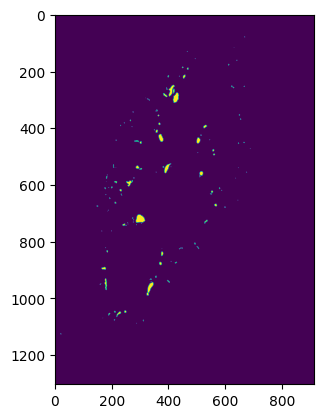

In [18]:
decoded_pred = rle_decode(rle, (pred.shape[0], pred.shape[1]))
plt.imshow(decoded_pred)

In [19]:
data_name = "kidney_1_dense"
data_id_list = []
rle_list = []
for slice_id in tqdm(range(500, 600)):
    data_id = f"{data_name}_{slice_id:04d}"
    image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id:04d}.tif", cv2.IMREAD_GRAYSCALE)
    pred, pred_counts = model.overlap_predict(image)
    rle = rle_encode((pred > 0.5).astype(np.uint8))
    rle_list.append(rle)
    data_id_list.append(data_id)

/tmp/ipykernel_24215/3404337702.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for slice_id in tqdm(range(500, 600)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
submit = pd.DataFrame({
    "id": data_id_list,
    "rle": rle_list
})

# submit = pd.read_csv("/kaggle/input/submission_sample.csv")
submit

,id,rle
0,kidney_1_dense_0500,119938 2 120850 2 121763 1 148384 3 149296 2 1...
1,kidney_1_dense_0501,47129 1 120850 1 121761 3 122673 3 123586 2 14...
2,kidney_1_dense_0502,75454 2 76367 1 91685 1 92596 2 93508 3 94420 ...
3,kidney_1_dense_0503,73628 2 74541 1 75454 1 124498 1 125409 3 1263...
4,kidney_1_dense_0504,86214 1 123590 2 124502 2 125413 3 126325 2 12...
...,...,...
95,kidney_1_dense_0595,131047 1 131959 2 132871 2 147254 1 148166 1 1...
96,kidney_1_dense_0596,132897 1 148458 1 190132 1 191043 3 191956 2 1...
97,kidney_1_dense_0597,191957 1 192868 2 193780 3 194692 3 195605 2 1...
98,kidney_1_dense_0598,91806 3 92718 3 93631 2 133781 1 134693 1 1627...


In [21]:
label = pd.read_csv("/kaggle/input/blood-vessel-segmentation/train_rles.csv")
label = label[label["id"].str.startswith(data_name)]
label = label[label["id"].isin(data_id_list)].reset_index(drop=True)
add_size_columns(label)
label

,id,rle,width,height,image_id,slice_id
0,kidney_1_dense_0500,80795 1 81707 1 119026 2 119938 2 120850 2 121...,912,1303,kidney_1_dense,0500
1,kidney_1_dense_0501,79883 1 80795 1 120850 1 121762 2 122674 2 123...,912,1303,kidney_1_dense,0501
2,kidney_1_dense_0502,79883 1 80795 1 90773 1 91685 1 92597 1 93508 ...,912,1303,kidney_1_dense,0502
3,kidney_1_dense_0503,78970 2 79882 2 80795 1 88949 1 89861 1 90773 ...,912,1303,kidney_1_dense,0503
4,kidney_1_dense_0504,72581 3 73492 2 73495 2 74408 2 78059 1 78970 ...,912,1303,kidney_1_dense,0504
...,...,...,...,...,...,...
95,kidney_1_dense_0595,171944 1 172856 1 181921 1 182833 1 183745 1 1...,912,1303,kidney_1_dense,0595
96,kidney_1_dense_0596,89985 1 90897 1 171944 1 172856 1 180096 1 181...,912,1303,kidney_1_dense,0596
97,kidney_1_dense_0597,90897 1 91808 2 172797 1 172856 1 173709 1 174...,912,1303,kidney_1_dense,0597
98,kidney_1_dense_0598,91807 2 92719 2 93631 1 160939 1 161851 1 1627...,912,1303,kidney_1_dense,0598


In [22]:
submit["id"]

0     kidney_1_dense_0500
1     kidney_1_dense_0501
2     kidney_1_dense_0502
3     kidney_1_dense_0503
4     kidney_1_dense_0504
             ...         
95    kidney_1_dense_0595
96    kidney_1_dense_0596
97    kidney_1_dense_0597
98    kidney_1_dense_0598
99    kidney_1_dense_0599
Name: id, Length: 100, dtype: object

In [23]:
label["id"]

0     kidney_1_dense_0500
1     kidney_1_dense_0501
2     kidney_1_dense_0502
3     kidney_1_dense_0503
4     kidney_1_dense_0504
             ...         
95    kidney_1_dense_0595
96    kidney_1_dense_0596
97    kidney_1_dense_0597
98    kidney_1_dense_0598
99    kidney_1_dense_0599
Name: id, Length: 100, dtype: object

In [24]:
submit["id"]==label["id"]

0     True
1     True
2     True
3     True
4     True
      ... 
95    True
96    True
97    True
98    True
99    True
Name: id, Length: 100, dtype: bool

In [25]:
(submit["id"] == label["id"]).all()

True

In [26]:
%%time
# Compute surface Dice score
score = compute_surface_dice_score(submit, label)
score

CPU times: user 212 ms, sys: 35.3 ms, total: 247 ms
Wall time: 242 ms


0.8320055603981018